In [4]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt # Import matplotlib.pyplot and assign it to plt
                                 # This makes the 'plt' object available for use

In [5]:
# Load the Dataset
data = pd.read_csv('SPY.csv')
data['Volume'] = data['Volume'].astype(str)  # Convert to string
data['Volume'] = data['Volume'].str.replace('M', '')  # Remove 'M'
data['Volume'] = data['Volume'].astype(float) * 1e6   # Convert to float and scale
data.head()



,Date,Close,Open,High,Low,Volume,Change %
0,12/18/14,206.78,204.74,212.97,203.92,257630000.0,2.47%
1,12/19/14,206.52,206.43,207.33,205.61,245080000.0,-0.13%
2,12/22/14,207.47,206.75,207.47,206.46,148320000.0,0.46%
3,12/23/14,207.75,208.17,208.23,207.40,122170000.0,0.13%
4,12/24/14,207.77,208.02,208.34,207.72,42960000.0,0.01%


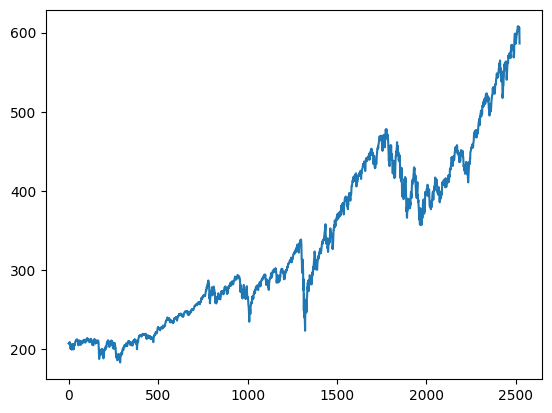

In [6]:
# Visualize the Close Data
data['Close'].plot()
plt.show()

In [135]:
# Split Data into Training and Testing Sets
train_data = data.iloc[:int(0.99 * len(data)), :]
test_data = data.iloc[int(0.99 * len(data)):, :]



In [143]:
# Convert 'Volume' to numeric (remove 'M' and scale to actual numbers)
data['Volume'] = data['Volume'].astype(str).str.replace('M', '').astype(float) * 1e6


# Fill missing values in 'Volume' with the median value
data['Volume'].fillna(data['Volume'].median(), inplace=True)

# Feature Engineering
data['High-Low'] = data['High'] - data['Low']  # Price range for the day
data['Open-Close'] = data['Open'] - data['Close']  # Difference between open and close prices
data['SMA_5'] = data['Close'].rolling(window=5).mean()  # 5-day Simple Moving Average
data['SMA_20'] = data['Close'].rolling(window=20).mean()  # 20-day Simple Moving Average

# Define the features and target
features = ['Open', 'Volume', 'High-Low', 'Open-Close', 'SMA_5', 'SMA_20']
target = 'Close'


<ipython-input-143-084b008d04f3>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Volume'].fillna(data['Volume'].median(), inplace=True)


In [152]:
# Replace infinity with NaN in numeric columns only
train_data[train_data.select_dtypes(include=[np.number]).columns] = (
    train_data.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)
)
test_data[test_data.select_dtypes(include=[np.number]).columns] = (
    test_data.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)
)

# Fill NaN values in numeric columns only
train_data[train_data.select_dtypes(include=[np.number]).columns] = (
    train_data.select_dtypes(include=[np.number]).fillna(train_data.median(numeric_only=True))
)
test_data[test_data.select_dtypes(include=[np.number]).columns] = (
    test_data.select_dtypes(include=[np.number]).fillna(test_data.median(numeric_only=True))
)


# Replace inf and -inf with NaN
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with column median (numeric columns only)
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_data[numeric_columns] = train_data[numeric_columns].fillna(train_data[numeric_columns].median())

# Replace inf and -inf in target column
train_data[target] = train_data[target].replace([np.inf, -np.inf], np.nan)

# Fill NaN values in the target column with its median
train_data[target] = train_data[target].fillna(train_data[target].median())




In [158]:
# Replace Inf and -Inf with NaN in features and target
train_data[features] = train_data[features].replace([np.inf, -np.inf], np.nan)
train_data[target] = train_data[target].replace([np.inf, -np.inf], np.nan)

# Fill NaN values with median
train_data[features] = train_data[features].fillna(train_data[features].median())
train_data[target] = train_data[target].fillna(train_data[target].median())

# Clip extreme values in features
upper_limit = train_data[features].quantile(0.99)
lower_limit = train_data[features].quantile(0.01)
train_data[features] = train_data[features].clip(lower=lower_limit, upper=upper_limit, axis=1)

# Optional: Clip extreme values in target (if applicable)
target_upper_limit = train_data[target].quantile(0.99)
target_lower_limit = train_data[target].quantile(0.01)
train_data[target] = train_data[target].clip(lower=target_lower_limit, upper=target_upper_limit)



In [166]:
test_data[features] = test_data[features].replace([np.inf, -np.inf], np.nan)
test_data[features] = test_data[features].fillna(test_data[features].median())


In [168]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data['Volume'] = scaler.fit_transform(train_data[['Volume']])
test_data['Volume'] = scaler.transform(test_data[['Volume']])

# Replace extreme values in Volume
train_data = train_data[train_data['Volume'] < 1e10]  # Filter out excessively large values

print(train_data[features].describe())



              Open       Volume     High-Low   Open-Close        SMA_5  \
count  2421.000000  2421.000000  2421.000000  2421.000000  2421.000000   
mean    335.102677     0.000000     3.775903    -0.045105   334.996922   
std     103.271965     1.000207     2.838099     2.686267   102.950142   
min     191.163600    -1.242485     0.620000    -7.350000   191.020480   
25%     246.740000    -0.657760     1.680000    -1.350000   247.042000   
50%     303.430000    -0.242369     2.960000    -0.150000   304.182000   
75%     419.770000     0.335806     4.920000     0.980000   419.162000   
max     572.868400     4.530118    14.559200     9.195200   571.779120   

            SMA_20  
count  2421.000000  
mean    334.429346  
std     101.671444  
min     192.428880  
25%     249.059000  
50%     303.969250  
75%     417.250500  
max     568.219540  


In [172]:
!pip install -U scikit-learn


In [173]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

# Generate sample data
X, y = make_regression(n_samples=100, n_features=5, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the XGBoost model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)
print(predictions)


[ 142.89313  -221.88446    59.731777  194.23416   258.3086     38.311882
  159.2278   -130.0051    -13.41709   -56.90638    68.06592   -83.30372
  -52.74189    61.16903   -27.994747 -146.38425   -29.990528  108.397125
  -23.92834    28.13556 ]


In [178]:
# Model initialization
model = XGBRegressor(
    base_score=0.5,   # Initial prediction score, typically the mean of the target variable
    booster='gbtree',   # Type of booster to use ('gbtree', 'gblinear', or 'dart')
    learning_rate=0.1,   # Step size shrinkage to prevent overfitting
    max_depth=6,        # Maximum depth of a tree; controls model complexity
    n_estimators=100,   # Number of boosting rounds (trees)
    random_state=42   # Seed for reproducibility
)

# Train the XGBoost model using the training data
model.fit(train_data[features], train_data[target])

# Make predictions on the test data
predictions = model.predict(test_data[features])

# Print the predictions to verify results
print(predictions)



[572.22504 572.2308  571.3709  572.48315 571.392   571.4897  571.09424
 571.77    572.4392  572.39746 572.3881  572.75964 570.39526 570.3131
 572.3138  572.7314  570.4711  572.64307 572.64307 572.31226 572.19617
 572.1727  572.5205  572.0939  566.3845 ]


In [176]:
# Make and show the predictions on train_data and test_data
predictions = model.predict(test_data[features])
print("Model Predictions:", predictions)


Model Predictions: [572.22504 572.2308  571.3709  572.48315 571.392   571.4897  571.09424
 571.77    572.4392  572.39746 572.3881  572.75964 570.39526 570.3131
 572.3138  572.7314  570.4711  572.64307 572.64307 572.31226 572.19617
 572.1727  572.5205  572.0939  566.3845 ]


In [177]:
# Show the actual target values
print('Actual Values:')
print(test_data[target])

Actual Values:
2497    597.19
2498    593.35
2499    585.75
2500    588.15
2501    590.30
2502    590.50
2503    593.67
2504    595.51
2505    597.53
2506    600.65
2507    598.83
2508    602.55
2509    603.63
2510    603.91
2511    607.66
2512    606.66
2513    607.81
2514    604.68
2515    602.80
2516    607.46
2517    604.33
2518    604.21
2519    606.79
2520    604.29
2521    586.28
Name: Close, dtype: float64


In [134]:
# Show the models accuracy
accuracy = model.score(test_data[features], test_data[target])
print('Accuracy:')
print(accuracy)

Accuracy:
0.9998165441058084
